# Applying Generalised Approach 
$L=\pi^TD^TD\pi+\lambda(1-\sum_i\pi_i)$ \
where \
$D_{\alpha, i}=\Delta f^{\mu(\alpha)}_i[t(\alpha)]$ 

# Set Up

In [1]:
import numpy as np
import seaborn as sns
from scipy.linalg import eig
import matplotlib.pyplot as plt 

from modules.LDS import Kalman_EM, calc_ALS
from modules.WF_sim import *

from scipy.optimize import minimize
from scipy.optimize import nnls
from pathlib import Path

Total counts shape:  (20, 10)
(20, 50, 10)


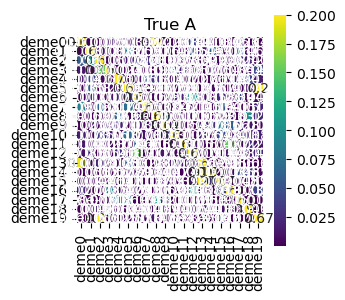

In [2]:
ND = 20 # the number of demes 
T=10 # the number of timepoints
Csn =[0.0]*ND # strength of measurement noise overdispersion
Npop = [10000]*ND # effective population size
if ND == 3:
    totcounts=np.array([[2000,3000,1500]]*T).T # number of sequences sampled from each region
elif ND > 3:
    totcounts = np.random.randint(1000, 3000, size=(ND, T))  # random counts for each deme at each timepoint
print("Total counts shape: ", totcounts.shape)

Ntraj = 50 # number of trajectories to simulate
A,counts,B=WF_sim(Npop, totcounts, Csn, ND, T, A=None, Ntraj=Ntraj)
print(counts.shape)
demes=['deme'+str(i) for i in range(ND)]

freqs = counts / (totcounts[:,None,:]) #calculating frequencies over all trajectories

plt.figure(figsize=[3,3])
sns.heatmap(A,cmap='viridis',vmax=0.2,annot=True,xticklabels=demes, yticklabels=demes,square=True)
plt.title('True A')
plt.show()

# find the lowest left eigenvector of A
eigvals, eigvecs = eig(A, left=True, right=False)
# normalize the eigenvectors
eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
eigvec_true = -eigvecs[:, np.argmax(eigvals.real)]
ordering = np.flip(np.argsort(eigvals.real))
eigvals = eigvals[ordering]
eigvecs = eigvecs[:,ordering]

In [3]:
list(range(4,5))

[4]

In [4]:
#manufacturing the D matrix, and solving for initial pi values
def D_mat(freqs, τ=1):
    ND, Ntraj, T = freqs.shape
    df_rows = []
    for mu in range(Ntraj):
        if τ == -1:
            for t in range(T):
                for tau in range(t+1,T):
                    delta_f=freqs[:,mu,tau]-freqs[:,mu,t]
                    delta_f *= (1-0.0**(np.abs(tau-t)))
                    df_rows.append(delta_f)
        else:
            for t in range(T-τ):
                delta_f=freqs[:,mu,t+τ]-freqs[:,mu,t]
                df_rows.append(delta_f)
    D=np.stack(df_rows, axis=0)
    return D
def base_L(pi, freqs, lamb):
    D =D_mat(freqs)
    D_pi= D@ pi
    mat=D_pi.T @ D_pi
    L= mat + lamb*(1-np.sum(pi))

def grad_base_L(pi, freqs, lamb):
    D=D_mat(freqs)
    grad_L=2*(D.T @ D) @ pi - lamb
    return grad_L

def pi_finder_simple(freqs, τ=1):
    ND, Ntraj, T = freqs.shape
    D=D_mat(freqs, τ)
    one=np.ones(ND)
    lamb_inv=(one.T @ np.linalg.inv(D.T @ D) @ one)/2
    lamb=1/lamb_inv
    pi=lamb/2 * np.linalg.inv(D.T @ D) @ one
    return pi

from cvxopt import matrix, solvers

def pi_qp(D):
  # Quadratic programming to solve for pi*

  ND = D.shape[1]
  P = matrix(2 * (D.T @ D))  # Quadratic term (must be symmetric)
  q = matrix(np.zeros(ND))   # Linear term

  # Constrain pi >= 0
  G = matrix(-np.eye(ND))    # -pi <= 0
  h = matrix(np.zeros(ND))
  # Constrain sum(pi) = 1
  A = matrix(np.ones((1, ND)))
  b = matrix(np.array([1.0]))

  sol = solvers.qp(P, q, G, h, A, b) # minimize (1/2)x'Px + q'x subject to Gx <= h, Ax = b
  pi_star = np.array(sol['x']).flatten()
  return pi_star

def pi_finder_qp(freqs, τ=1):
    D = D_mat(freqs, τ)
    
    pi_star = pi_qp(D)
    return pi_star

pi_star_qp = pi_finder_qp(freqs, τ=1)
pi_star=pi_finder_simple(freqs, τ=1)

print("Using qp solver:  ", pi_star_qp)
print("Using analytic:   ", pi_star)
print("Exact pi vector:  ", eigvec_true / np.sum(eigvec_true))

     pcost       dcost       gap    pres   dres
 0:  8.7544e-05 -1.0003e+00  1e+00  3e-16  5e+00
 1:  8.7457e-05 -1.0343e-02  1e-02  4e-17  5e-02
 2:  8.0703e-05 -3.8361e-04  5e-04  4e-17  2e-03
 3:  5.6085e-05 -1.1444e-05  7e-05  4e-17  2e-04
 4:  5.2280e-05  4.8613e-05  4e-06  2e-16  5e-06
 5:  5.2193e-05  5.2128e-05  6e-08  2e-16  5e-08
Optimal solution found.
Using qp solver:   [0.06585617 0.05224963 0.08287633 0.02706841 0.04823996 0.06233311
 0.05261772 0.03084843 0.0638443  0.03417272 0.02092291 0.0190311
 0.05598363 0.06096025 0.02540432 0.04310976 0.04552715 0.05535708
 0.09667334 0.05692368]
Using analytic:    [0.06586859 0.05227335 0.08289935 0.02705226 0.0482533  0.06235657
 0.05261681 0.03085736 0.06384348 0.03419153 0.02087234 0.01892932
 0.0560126  0.06094953 0.02538244 0.04310776 0.04551217 0.05537766
 0.09669389 0.05694969]
Exact pi vector:   [0.06431453-0.j 0.0524522 -0.j 0.07771601-0.j 0.02008208-0.j
 0.05142321-0.j 0.05642392-0.j 0.04658696-0.j 0.02680007-0.j
 0.077

[0.06882183+0.j 0.0494322 +0.j 0.08588551+0.j 0.02228499+0.j
 0.04522215+0.j 0.06319949+0.j 0.04360458+0.j 0.02421905+0.j
 0.06760791+0.j 0.0270462 +0.j 0.02011872+0.j 0.01470362+0.j
 0.04080414+0.j 0.06118646+0.j 0.03084833+0.j 0.03658152+0.j
 0.02886324+0.j 0.04614196+0.j 0.16296056+0.j 0.06046755+0.j]
[0.06431453-0.j 0.0524522 -0.j 0.07771601-0.j 0.02008208-0.j
 0.05142321-0.j 0.05642392-0.j 0.04658696-0.j 0.02680007-0.j
 0.07765597-0.j 0.03102047-0.j 0.01874939-0.j 0.01322018-0.j
 0.05435038-0.j 0.06009635-0.j 0.02196435-0.j 0.03917227-0.j
 0.02434838-0.j 0.04042727-0.j 0.1663776 -0.j 0.0568184 -0.j]
[0.06586859 0.05227335 0.08289935 0.02705226 0.0482533  0.06235657
 0.05261681 0.03085736 0.06384348 0.03419153 0.02087234 0.01892932
 0.0560126  0.06094953 0.02538244 0.04310776 0.04551217 0.05537766
 0.09669389 0.05694969]


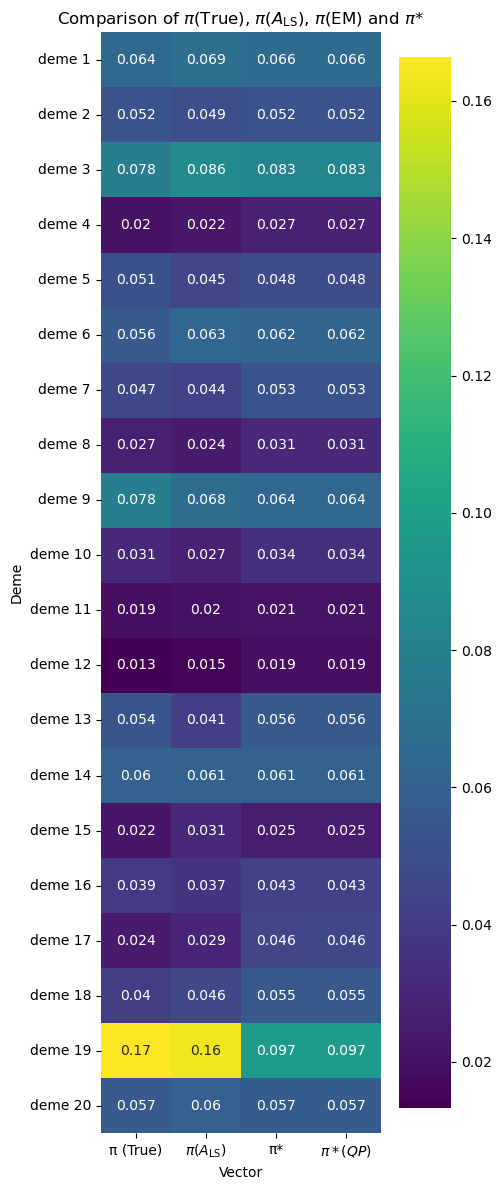

In [5]:
#lnLH_record, A_EM, Ne_EM, A_LS,Csn_EM=Kalman_EM(counts=counts+1, 
#                                             counts_deme=totcounts, 
#                                             em_step_max=100,terminate_th=0.001, 
#                                             frac=0.5,noisemode=2,Qprintstep=False)
A_LS = calc_ALS(counts+1, counts_deme=totcounts)


eigvals_LS, eigvecs_LS = eig(A_LS, left=True, right=False)
#eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
eigvec_LS = -eigvecs_LS[:, np.argmax(eigvals_LS.real)]
ordering = np.flip(np.argsort(eigvals_LS.real))
eigvals_LS = eigvals_LS[ordering]
eigvecs_LS = eigvecs_LS[:,ordering]
print (eigvec_LS/np.sum(eigvec_LS))
print(eigvec_true/np.sum(eigvec_true))
print(pi_star)

#lnLH_record, A_EM, Ne_EM, A_LS,Csn_EM=Kalman_EM(counts=counts+1, 
#                                             counts_deme=totcounts, 
#                                             em_step_max=100,terminate_th=0.001, 
#                                             frac=0.5,noisemode=2,Qprintstep=False)


"""eigvals_EM, eigvecs_EM = eig(A_EM, left=True, right=False)
#eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
eigvec_EM = -eigvecs_EM[:, np.argmax(eigvals_EM.real)]
ordering = np.flip(np.argsort(eigvals_EM.real))
eigvals_EM = eigvals_EM[ordering]
eigvecs_EM = eigvecs_EM[:,ordering]
print (eigvec_EM/np.sum(eigvec_EM))"""

# Ensure real values
eigvec_real = np.real(eigvec_LS)
eigvec_true_real = np.real(eigvec_true)
#eigvec_EM_real=np.real(eigvec_EM)
pi_star_real = np.real(pi_star)

# Normalize
eigvec_norm = eigvec_real / np.sum(eigvec_real)
eigvec_true_norm = eigvec_true_real / np.sum(eigvec_true_real)
#eigvec_EM_norm = eigvec_EM_real / np.sum(eigvec_EM_real)
pi_star_norm = pi_star_real / np.sum(pi_star_real)

# Stack and transpose: shape (ND, 3)
data = np.vstack([eigvec_true_norm, eigvec_norm, pi_star_norm, pi_star_qp]).T

# Labels
ylabels = [f'deme {i+1}' for i in range(len(pi_star))]
xlabels = ['π (True)', r'$\pi(A_{\mathrm{LS}})$', 'π*', r'$\pi* (QP)$']

plt.figure(figsize=(5, len(pi_star) * 0.5 + 2))
sns.heatmap(data, annot=True, cmap='viridis', cbar=True, xticklabels=xlabels, yticklabels=ylabels)
plt.title(r'Comparison of $\pi$(True), $\pi(A_{\mathrm{LS}})$, $\pi$(EM) and $\pi$*')
plt.xlabel('Vector')
plt.ylabel('Deme')
plt.tight_layout()
plt.show()

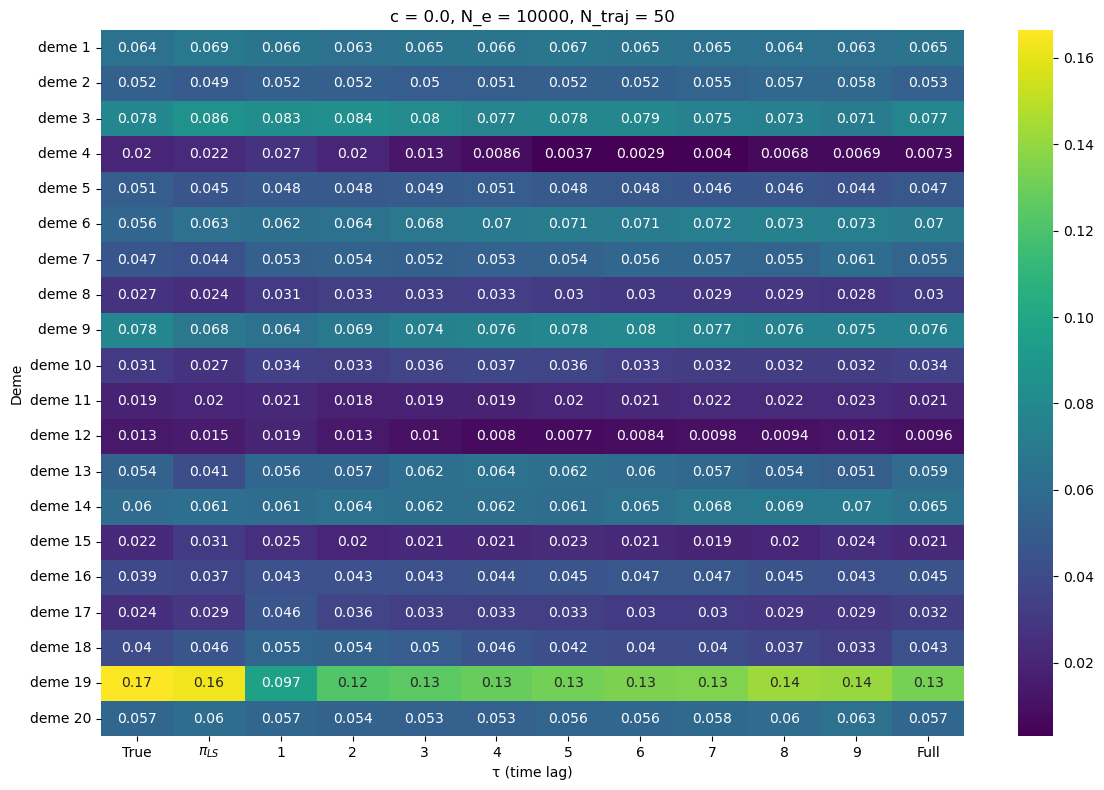

In [6]:
# find pi_star for time lags from 1 to T
pi_stars = []
for τ in range(1, T):
    pi_star = pi_finder_qp(freqs, τ=τ)
    pi_stars.append(pi_star)
pi_stars = np.array(pi_stars)
pi_star_full = pi_finder_qp(freqs, τ=-1)  # for τ = -1

pi_true = eigvec_true / np.sum(eigvec_true)
pi_LS = eigvec_LS/np.sum(eigvec_LS)
# Stack pi_true as the first column for comparison
pi_stars_with_true = np.column_stack([np.real(pi_true),np.real(pi_LS), pi_stars.T, pi_star_full])

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(pi_stars_with_true, cmap='viridis', annot=True, cbar=True, 
            xticklabels=['True', r"$\pi_{LS}$"] + list(np.arange(1, T)) + ['Full'], yticklabels=ylabels)
ax.set_xlabel('τ (time lag)')
ax.set_ylabel('Deme')
ax.set_title(f'c = {Csn[0]}, N_e = {Npop[0]}, N_traj = {Ntraj}')
plt.tight_layout()
plt.show()

In [ ]:
# run comparison systematically over demes
from tqdm import tqdm
pi_stars_all_demes = []
ND_min=2
ND_max=50
NDs = np.arange(ND_min, ND_max+1, 2)
NDs = np.repeat(NDs, 5)  # repeat each ND value 10 times for multiple runs
for ND in tqdm(NDs):
    Csn = [0.0] * ND  # strength of measurement noise overdispersion
    Npop = [10000] * ND  # effective population size
    T = 10
    if ND == 3:
        totcounts = np.array([[2000, 3000, 1500]] * T).T  # number of sequences sampled from each region
    elif ND != 3:
        totcounts = np.random.randint(1000, 3000, size=(ND, T))  # random counts for each deme at each timepoint

    Ntraj = 50  # number of trajectories to simulate
    A, counts, B = WF_sim(Npop, totcounts, Csn, ND, T, A=None, Ntraj=Ntraj)
    freqs = counts / (totcounts[:, None, :])  # calculating frequencies over all trajectories

    # run Kalman EM
    A_LS = calc_ALS(counts+1, counts_deme=totcounts)
    
    eigvals_LS, eigvecs_LS = eig(A_LS, left=True, right=False)
    eigvec_LS = eigvecs_LS[:, np.argmax(eigvals_LS.real)]
    pi_LS = eigvec_LS / np.sum(eigvec_LS)

    pi_stars = []
    for τ in range(1, T):
        pi_star = pi_finder_qp(freqs, τ=τ)
        pi_stars.append(pi_star)
    pi_stars = np.array(pi_stars)
    pi_star_full = pi_finder_qp(freqs, τ=-1)  # for τ = -1

    eigvals, eigvecs = eig(A, left=True, right=False)
    # normalize the eigenvectors
    eigvecs = eigvecs / np.linalg.norm(eigvecs, axis=0)
    eigvec_true = -eigvecs[:, np.argmax(eigvals.real)]
    pi_true = eigvec_true / np.sum(eigvec_true)
    
    # Stack pi_true as the first column for comparison
    pi_stars_with_true = np.column_stack([np.real(pi_true), np.real(pi_LS), pi_stars.T, pi_star_full])
    
    pi_stars_all_demes.append(pi_stars_with_true)

 11%|█         | 14/125 [00:01<00:12,  9.17it/s]

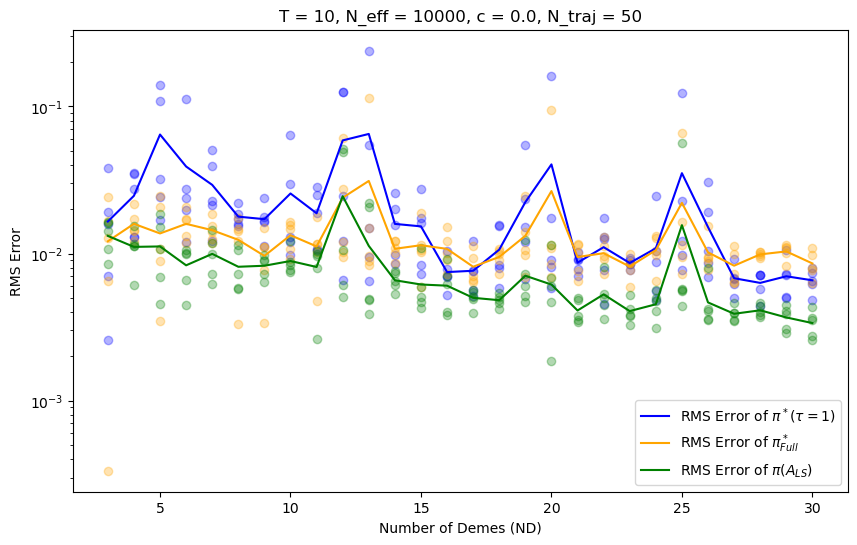

In [30]:
# rms error between pi and pi true
def rms_error(pi, pi_true):
    return np.sqrt(np.mean((pi - pi_true) ** 2))
# difference between largest component of pi and pi true
def max_component_error(pi, pi_true):
    return np.max(np.abs(pi - pi_true))

# Calculate RMS errors for each ND
pi_rms_errors = []
pi_max_errors = []
for pi_stars in pi_stars_all_demes:
    pi_true = pi_stars[:, 0]  # first column is the true pi
    pi_deme_errors = [rms_error(pi_stars[:, i], pi_true) for i in range(1, pi_stars.shape[1] - 1)]
    pi_deme_max_errors = [max_component_error(pi_stars[:, i], pi_true) for i in range(1, pi_stars.shape[1] - 1)]
    pi_rms_errors.append(pi_deme_errors)
    pi_max_errors.append(pi_deme_max_errors)
pi_rms_errors = np.array(pi_rms_errors)
pi_max_errors = np.array(pi_max_errors)
# average errors across data points for each ND
ND_uniques = np.unique(NDs)
pi_rms_avs = []
pi_max_avs = []
for ND in ND_uniques:
    mask = NDs == ND
    pi_rms_av = np.mean(pi_rms_errors[mask], axis=0)
    pi_rms_avs.append(pi_rms_av)

    pi_max_av = np.mean(pi_max_errors[mask], axis=0)
    pi_max_avs.append(pi_max_av)

pi_rms_avs = np.array(pi_rms_avs)
pi_max_avs = np.array(pi_max_avs)
#print("RMS Errors for π*:", pi_LS_rms_errors)
# Plot RMS errors
plt.figure(figsize=(10, 6))
plt.scatter(NDs, pi_rms_errors[:, 1]
            , marker='o', color='blue', alpha=0.3)
plt.scatter(NDs, pi_rms_errors[:, -1]
            , marker='o', color='orange', alpha=0.3)
plt.scatter(NDs, pi_rms_errors[:, 0]
            , marker='o', color='green', alpha=0.3)
plt.plot(ND_uniques, pi_rms_avs[:, 1], label=r'RMS Error of $\pi^*(\tau=1)$', color='blue')
plt.plot(ND_uniques, pi_rms_avs[:, -1], label=r'RMS Error of $\pi^*_{Full}$', color='orange')
plt.plot(ND_uniques, pi_rms_avs[:, 0], label=r'RMS Error of $\pi(A_{LS})$', color='green')
plt.xlabel('Number of Demes (ND)')
plt.ylabel('RMS Error')
#plt.ylim(0, 0.04)
plt.yscale('log')

plt.title(f'T = {T}, N_eff = {Npop[0]}, c = {Csn[0]}, N_traj = {Ntraj}')
plt.legend()

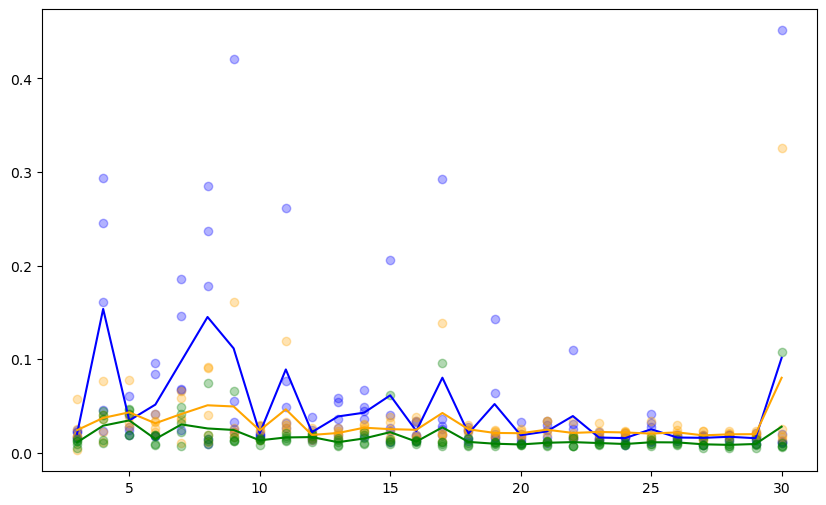

In [21]:
# plot max component errors
plt.figure(figsize=(10, 6))
plt.scatter(NDs, pi_max_errors[:, 1]
            , marker='o', color='blue', alpha=0.3)
plt.scatter(NDs, pi_max_errors[:, -1]
            , marker='o', color='orange', alpha=0.3)
plt.scatter(NDs, pi_max_errors[:, 0]
            , marker='o', color='green', alpha=0.3)
plt.plot(ND_uniques, pi_max_avs[:, 1],
          label=r'Max Component Error of $\pi^*(\tau=1)$', color='blue')
plt.plot(ND_uniques, pi_max_avs[:, -1],
          label=r'Max Component Error of $\pi^*_{Full}$', color='orange')
plt.plot(ND_uniques, pi_max_avs[:, 0],
          label=r'Max Component Error of $\pi(A_{LS})$', color='green')

#### Bootstrap

In [56]:
#bootstrapping 
#essential idea of bootstrapping - trying to generate new data sets, same size as original, to create prob distribution of mean and s.d.
n_B = 1000 #number of bootstraps
def bootstrapping(freqs, n_B, seed=None): #paramterise by the frequency, number of bootstraps, and seed (used in random nummber generator)
    Nd, Ntraj, T = freqs.shape 
    numb=np.random.default_rng(seed) #ensures numbers are randomly generated all the time

    ps = [] #initialise list

    for b in range(n_B): #iterate over bootstrap numbers
        n_traj_new=numb.choice(Ntraj, size=Ntraj, replace=True) #generates a new array of random trajectories to use to 'shuffle around' frequencies
        freqs_bootstrap = freqs[:,n_traj_new,:] #creates bootstrapped frequency data sets

        #now run existing pi finder

        try: 
            pi_new = pi_finder_simple(freqs_bootstrap) #apply pi finder to new frequency
            ps.append(pi_new) #append list
        except Exception as e: #check for errors 
            print(f'{b} failed: {e}')
        if b % 100 == 0:
            print(f'Bootstrap {b}/{n_B}') #check for what stage we're at for large n_B
    ps=np.stack(ps) #turns list into matrix of pi vectors at differen boot straps

    

    ps_mean=np.mean(ps, axis=0) #gives the mean
    ps_std=np.std(ps, axis=0) #gives the standard deviation
    ps_lower=np.percentile(ps, 2.5, axis=0)
    ps_upper=np.percentile(ps, 97.5, axis=0) #gives confidence interva;
    return ps, ps_mean, ps_std, ps_lower, ps_upper

pis, pis_mean, pis_std, pis_lower, pis_upper = bootstrapping(freqs, n_B)
print (pis_mean)
print ("------")
print (pis_std)

Bootstrap 0/1000
Bootstrap 100/1000
Bootstrap 200/1000
Bootstrap 300/1000
Bootstrap 400/1000
Bootstrap 500/1000
Bootstrap 600/1000
Bootstrap 700/1000
Bootstrap 800/1000
Bootstrap 900/1000
[0.11485173 0.1166447  0.12328088 0.09848321 0.12991323 0.11251466
 0.08145942 0.09370407 0.06051656 0.06863154]
------
[0.01519194 0.01419509 0.01968585 0.01959796 0.01870969 0.01264698
 0.01599614 0.0168735  0.01765689 0.0120881 ]


<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
C:\Users\nicho\AppData\Local\Temp\ipykernel_33644\932491609.py:4: SyntaxWarning: invalid escape sequence '\p'
  plt.hist(pis[:, i], bins=30, alpha=0.5, label=f"$\pi_{i}$", density=True)
C:\Users\nicho\AppData\Local\Temp\ipykernel_33644\932491609.py:5: SyntaxWarning: invalid escape sequence '\p'
  plt.axvline(pi_star[i], color='k', linestyle='--', linewidth=2, label=f"$\pi^*_{{{i}}}$")
C:\Users\nicho\AppData\Local\Temp\ipykernel_33644\932491609.py:8: SyntaxWarning: invalid escape sequence '\p'
  plt.title('Bootstrap Distribution of $\pi_i$ Components')


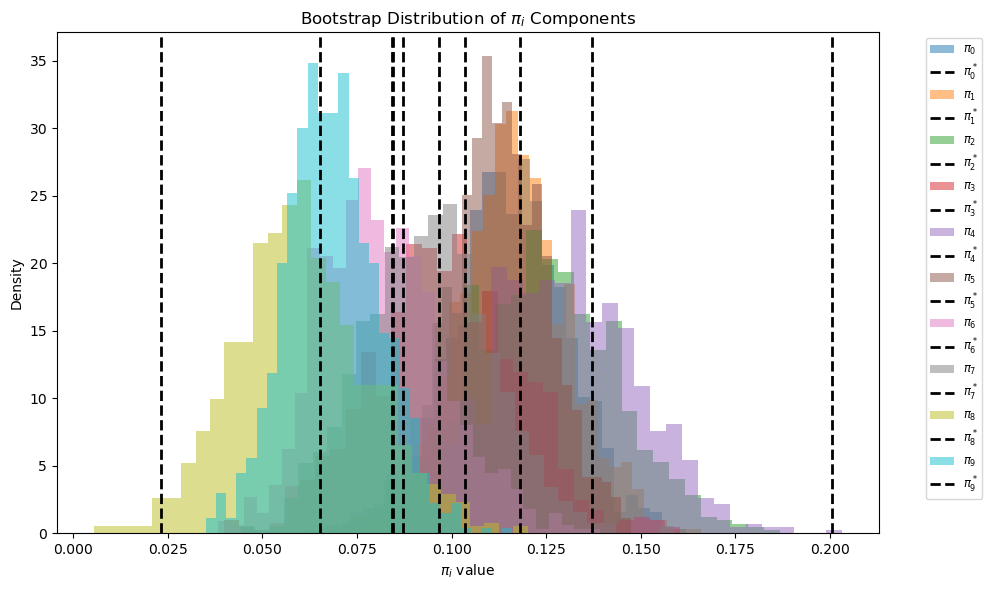

In [57]:
# pis shape: (n_B, ND)
plt.figure(figsize=(10, 6))
for i in range(pis.shape[1]):
    plt.hist(pis[:, i], bins=30, alpha=0.5, label=f"$\pi_{i}$", density=True)
    plt.axvline(pi_star[i], color='k', linestyle='--', linewidth=2, label=f"$\pi^*_{{{i}}}$")
plt.xlabel(r'$\pi_i$ value')
plt.ylabel('Density')
plt.title('Bootstrap Distribution of $\pi_i$ Components')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

#### Using solver package for c

In [58]:
def F_setup(freqs, τ, pi, totcounts):
    ND, Ntraj, T=freqs.shape
    F=np.zeros((ND, Ntraj, T-τ))
    df = np.zeros((ND, Ntraj, T-τ))
    for i in range(ND):
        for u in range(Ntraj):
            for t in range(T-τ):
                F[i,u,t]=pi[i]**2*(freqs[i,u,t+τ]/totcounts[i,t+1]+freqs[i,u,t]/totcounts[i,t])
                df[i,u,t]=freqs[i,u,t+τ]-freqs[i,u,t]
    return F, df

F, df = F_setup(freqs, τ, pi_star, totcounts)

def F_fancy_setup(pi, freqs, τ, totcounts):
    
    F, _=F_setup(freqs, τ, pi, totcounts)
    
    F_fancy = np.transpose(F, (1, 2, 0))  # (Ntraj, T-1, ND)
    F_fancy = F_fancy.reshape(-1, len(pi)) 
    return F_fancy

F_fancy=F_fancy_setup(pi_star, freqs, τ, totcounts)

def beta_setup(pi, freqs, τ, totcounts):
    _, df =F_setup(freqs, τ, pi, totcounts)
    df = np.transpose(df, (1,2,0)).reshape(-1, len(pi))
    print(df.shape)
    dot=df @ pi
    beta= dot**2
    return beta    

def c_finder(pi, freqs, totcounts):
    F_fancy=F_fancy_setup(pi, freqs, τ, totcounts)
    beta=beta_setup(pi, freqs, τ, totcounts)
    c=np.linalg.pinv(F_fancy)@beta
    c2=nnls(F_fancy, beta)
    return c, c2

def c_finder_qp(pi, freqs, τ, totcounts):
    # Using quadratic programming to find c
    # c* = argmin_c ||F_fancy c - beta||^2
    # constrain c >= 1

    ND = freqs.shape[0]

    F_fancy = F_fancy_setup(pi, freqs, τ, totcounts)
    beta = beta_setup(pi, freqs, τ, totcounts)
    P = matrix(F_fancy.T @ F_fancy)  # Quadratic term
    q = matrix(-F_fancy.T @ beta)    # Linear term

    # Constraints: c >= 1
    # Gx <= h  -->  -c <= -1  -->  G = -I, h = -1
    G = -matrix(np.eye(ND))
    h = -matrix(np.zeros(ND))  # Why does np.zeros work here? Why not np.ones?

    # No equality constraints
    A = None
    b = None

    sol = solvers.qp(P, q, G, h, A, b)
    c_star = np.array(sol['x']).flatten()
    return c_star

τ = 5
pi_star = pi_finder_qp(freqs, τ=τ)
#c, c2=c_finder(pi_star, freqs, totcounts)
c_cp = c_finder_qp(pi_star, freqs, τ, totcounts)

#print(c)
print(c_cp)
print("c true:", Csn)

(250, 10)
[1.14074304 1.23599868 1.31034908 1.19164484 1.12193745 1.12206684
 1.07051426 1.13004115 1.13273646 1.04640185]
c true: [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]


#### How does $\pi \cdot f$ change over time?

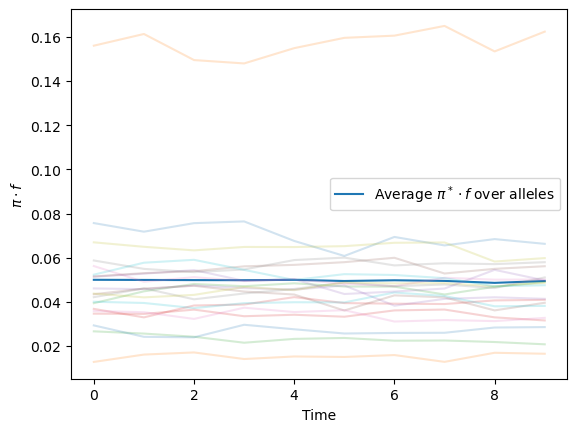

In [202]:
freqs.shape # (3, 20, 10)
pi_1 = np.array([np.dot(pi_star, freqs[:,i,:]) for i in range(freqs.shape[1])])
pi_dot_f = np.mean(pi_1, axis=0)  # (3, 20*10)
pi_dot_f.shape
plt.plot(pi_dot_f, label=r"Average $\pi^*\cdot f$ over alleles")
for pi_dot in pi_1:
    plt.plot(pi_dot, alpha=0.2)
plt.xlabel('Time')
plt.ylabel(r'$\pi \cdot f$')
plt.legend()